In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from tensorflow.keras.models import load_model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense
import joblib
import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/Tugas Akhir/BBTN.csv'

df = pd.read_csv(file_path)

In [4]:
df.head()

,date,previous,open_price,first_trade,high,low,close,change,volume,value,...,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,delisting_date,non_regular_volume,non_regular_value,non_regular_frequency
0,2019-07-29T00:00:00,2400.0,2400.0,2400.0,2410.0,2360.0,2390.0,-10.0,14447500.0,3.444723e+10,...,16300.0,1.048410e+10,1.048410e+10,1.048410e+10,6144100.0,58500.0,NaN,3145750.0,7.581002e+09,5.0
1,2019-07-30T00:00:00,2390.0,2380.0,2380.0,2460.0,2380.0,2450.0,60.0,14862600.0,3.613488e+10,...,105800.0,1.048410e+10,1.048410e+10,1.048410e+10,4275500.0,204000.0,NaN,2359500.0,5.683796e+09,3.0
2,2019-07-31T00:00:00,2450.0,2450.0,2440.0,2460.0,2420.0,2460.0,10.0,17919400.0,4.374584e+10,...,10000.0,1.048410e+10,1.048410e+10,1.048410e+10,8850700.0,3690200.0,NaN,2800401.0,6.846480e+09,10.0
3,2019-08-01T00:00:00,2460.0,2440.0,2440.0,2450.0,2380.0,2400.0,-60.0,19681000.0,4.721296e+10,...,327900.0,1.048410e+10,1.048410e+10,1.048410e+10,6396000.0,746400.0,NaN,4901392.0,1.179340e+10,9.0
4,2019-08-02T00:00:00,2400.0,2380.0,2380.0,2380.0,2320.0,2320.0,-80.0,25885800.0,6.061979e+10,...,1520100.0,1.048410e+10,1.048410e+10,1.048410e+10,8039800.0,4791500.0,NaN,5015050.0,1.184047e+10,7.0


### Transforming **Data**

In [5]:
df.drop(['open_price', 'high', 'low','volume','change','previous', 'first_trade', 'value', 'bid_volume','listed_shares','tradeble_shares','frequency', 'index_individual', 'offer', 'offer_volume', 'bid', 'non_regular_volume','weight_for_index', 'foreign_sell', 'foreign_buy', 'delisting_date', 'non_regular_value','non_regular_frequency'], axis=1, inplace=True)

In [6]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
NumCols = df.columns.drop(['date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

### **Checking Missing Values and Duplicates**

In [8]:
df.isnull().sum()

,0
date,0
close,0


In [9]:
df.duplicated().sum()

0

In [10]:
fig = px.line(y=df.close, x=df.date)
fig.update_traces(line_color='purple')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Close",
                  title={'text': "Close History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='lightblue')

# Data Scaling

In [11]:
close_prices = df['close'].values.reshape(-1, 1)

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [13]:
def create_dataset(data, time_step=3):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [14]:
time_step = 3
X, Y = create_dataset(scaled_data, time_step)

In [15]:
X = X.reshape(X.shape[0], X.shape[1], 1)

# Splitting Data to Training & Test Sets

In [16]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]
test_size


224

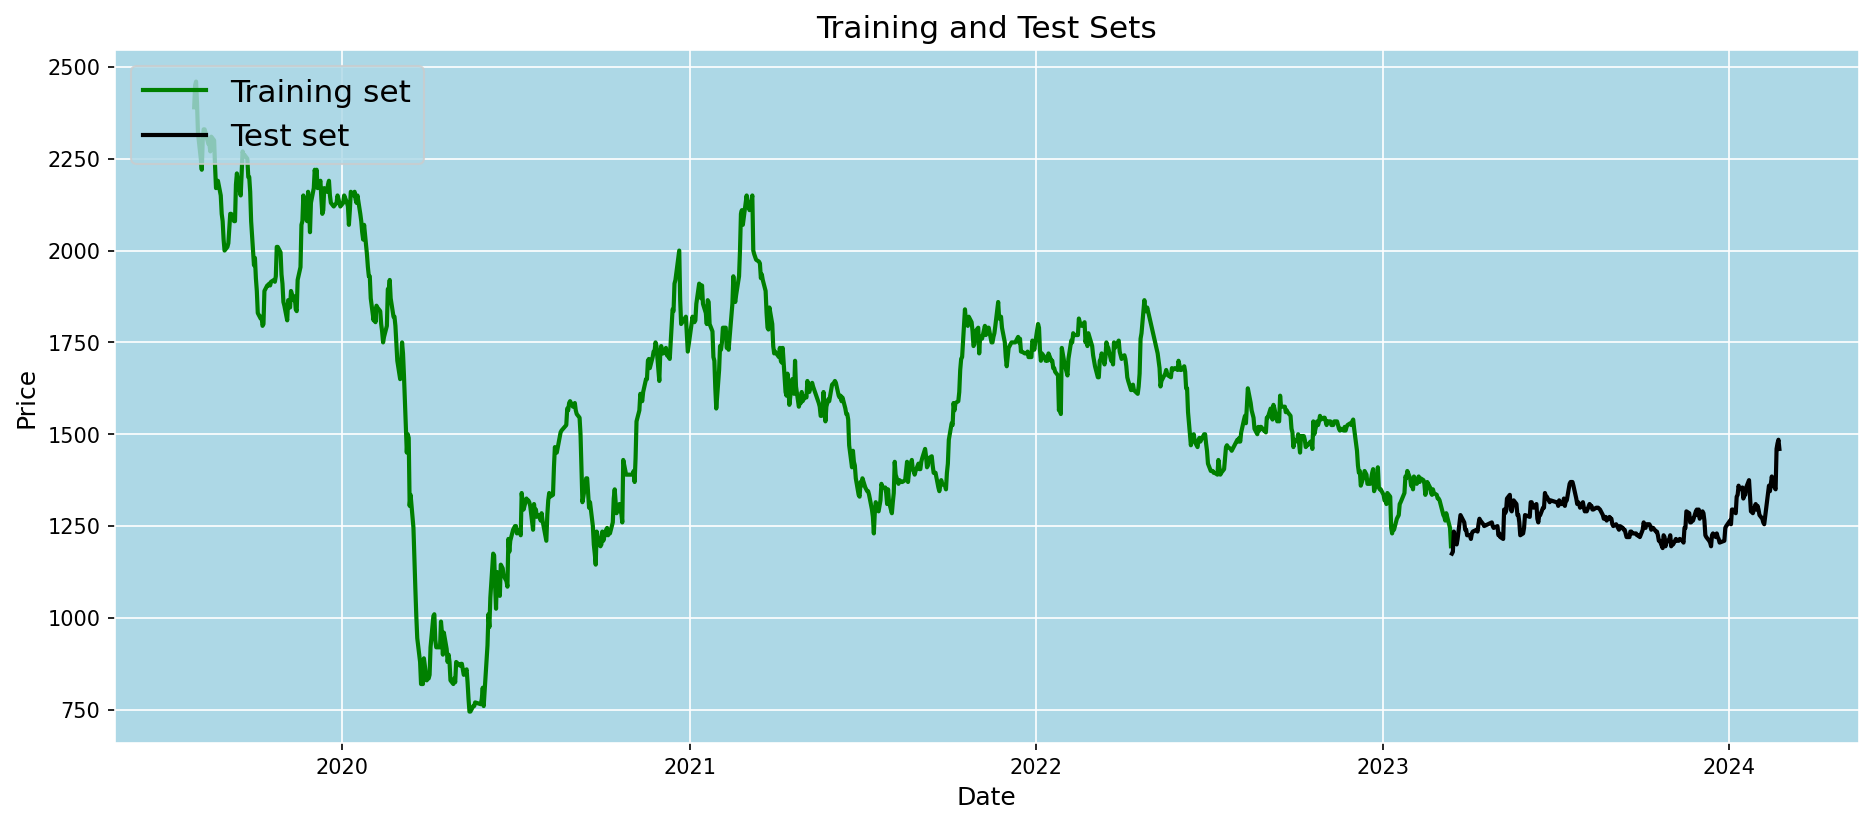

In [17]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'lightblue'
plt.rc('axes',edgecolor='white')
plt.plot(df.date[:-test_size], df.close[:-test_size], color='green', lw=2)
plt.plot(df.date[-test_size:], df.close[-test_size:], color='black', lw=2)
plt.title('Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [18]:
train_data = df.close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1, 1))

In [19]:
X_train = []
y_train = []

for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

In [20]:
test_data = df.close[-(test_size + time_step):]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [21]:
X_test = []
y_test = []

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])
    y_test.append(test_data[i, 0])

In [22]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [23]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [24]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (893, 3, 1)
y_train Shape:  (893, 1)
X_test Shape:   (224, 3, 1)
y_test Shape:   (224, 1)


Build a model LSTM

In [25]:
def define_model():
    input1 = Input(shape=(time_step,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32)(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='nadam')
    model.summary()

    return model

In [26]:
start_time = time.time()

model = define_model()
history = model.fit(X_train, y_train, epochs=200, batch_size=60, validation_split=0.1, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 3, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.2414 - val_loss: 0.0016
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0217 - val_loss: 0.0090
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0149 - val_loss: 0.0076
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0089 - val_loss: 0.0016
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0049 - val_loss: 4.3946e-04
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - val_loss: 7.5301e-04
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0040 - val_loss: 5.6341e-04
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 3.6120e-04
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034 - val_loss: 3.6801e-04
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034 - val_loss: 3.4435e-04
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 3.4462e-04
Epoch 12/200
14/14 ━━━━

In [27]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Total waktu eksekusi: {execution_time} detik")

Total waktu eksekusi: 87.69828009605408 detik


In [28]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4878e-04 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


In [29]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [30]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.00015243528469000012
Test MAPE: 0.025594741899079683
Test Accuracy: 0.9744052581009203


In [31]:
df_test = pd.DataFrame(y_test, columns=['Actual'])
df_pred = pd.DataFrame(y_pred, columns=['Predicted'])

In [32]:
comparison_df = pd.concat([df_test, df_pred], axis=1)

In [33]:
comparison_df['MAPE (%)'] = np.abs((comparison_df['Actual'] - comparison_df['Predicted']) / comparison_df['Actual']) * 100

In [34]:
print(comparison_df)

       Actual  Predicted   MAPE (%)
0    0.250729   0.264891   5.648292
1    0.253644   0.250525   1.229647
2    0.285714   0.250415  12.354720
3    0.265306   0.278249   4.878625
4    0.274052   0.264508   3.482825
..        ...        ...        ...
219  0.352770   0.362970   2.891469
220  0.416910   0.354880  14.878532
221  0.425656   0.410866   3.474626
222  0.431487   0.424898   1.527101
223  0.416910   0.433541   3.989212

[224 rows x 3 columns]


In [35]:
overall_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Overall MAPE: {overall_mape:.2f}%")

Overall MAPE: 2.56%


In [36]:
total_mape = comparison_df['MAPE (%)'].sum()

In [37]:
summary_row = pd.DataFrame({'Actual': ['Total'], 'Predicted': [''], 'MAPE (%)': [total_mape]})
comparison_df = pd.concat([comparison_df, summary_row])

print(comparison_df)

       Actual Predicted    MAPE (%)
0    0.250729  0.264891    5.648292
1    0.253644  0.250525    1.229647
2    0.285714  0.250415   12.354720
3    0.265306  0.278249    4.878625
4    0.274052  0.264508    3.482825
..        ...       ...         ...
220   0.41691   0.35488   14.878532
221  0.425656  0.410866    3.474626
222  0.431487  0.424898    1.527101
223   0.41691  0.433541    3.989212
0       Total            573.322219

[225 rows x 3 columns]


In [38]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

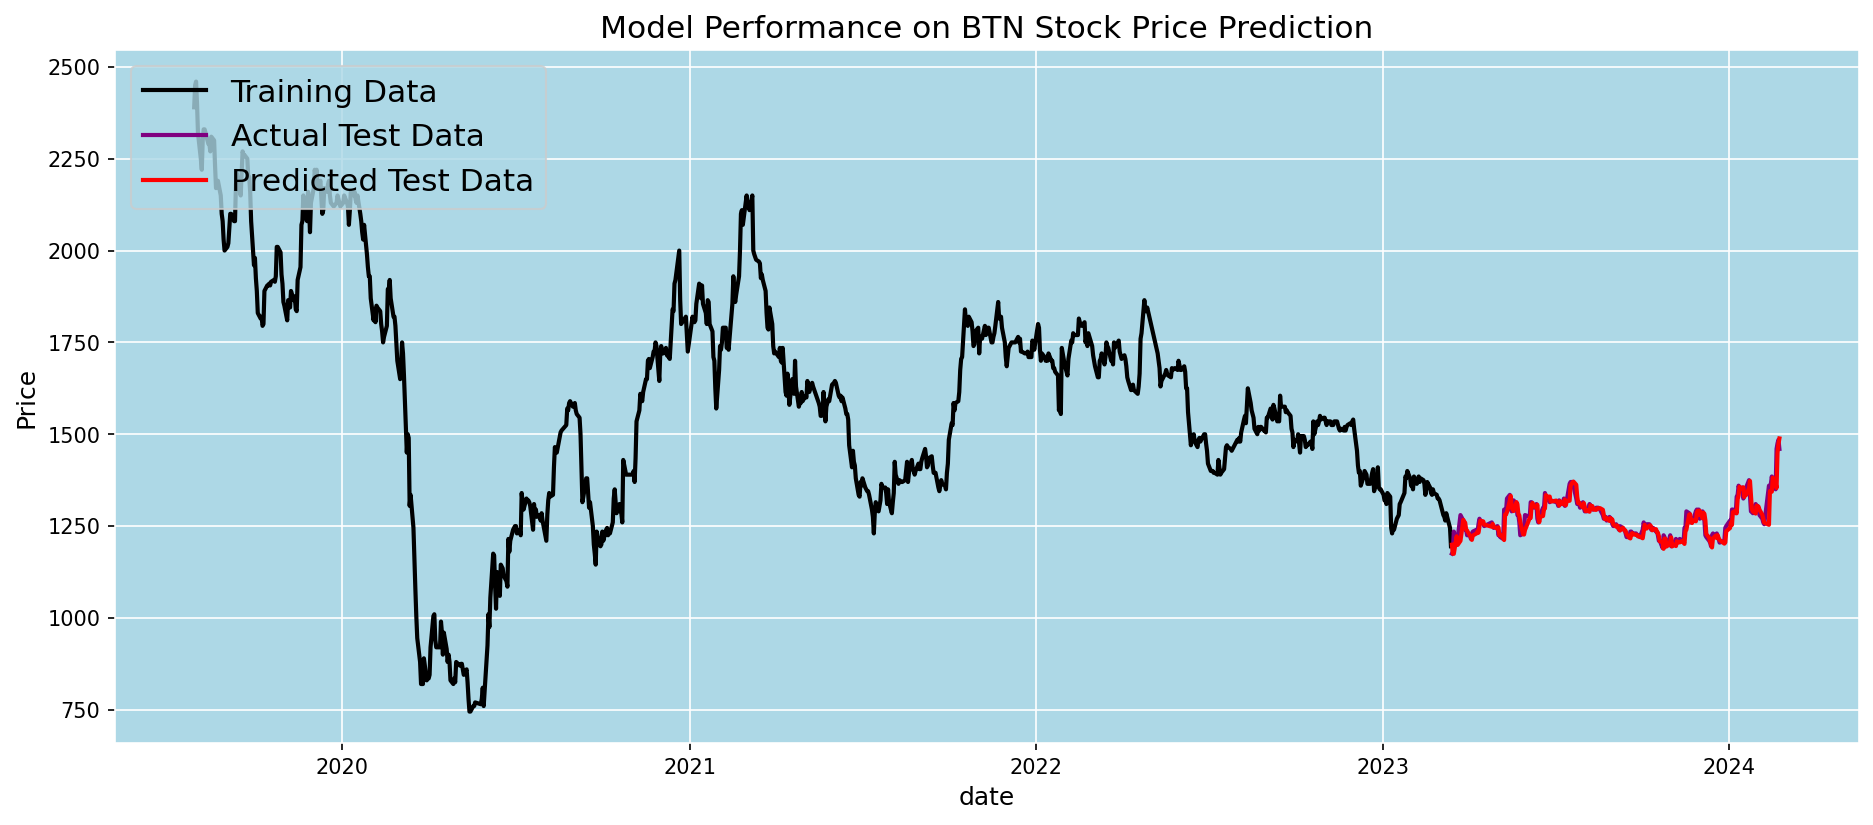

In [39]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'lightblue'
plt.rc('axes',edgecolor='white')
plt.plot(df['date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['date'].iloc[-test_size:], y_test_true, color='purple', lw=2)
plt.plot(df['date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on BTN Stock Price Prediction', fontsize=15)
plt.xlabel('date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [40]:
model.save('lstm_stock_model.h5')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [41]:
def predict_stock_price(model, scaler, last_3_days_prices):
    last_3_days_prices = np.array(last_3_days_prices).reshape(-1, 1)
    last_3_days_prices = scaler.transform(last_3_days_prices)
    last_3_days_prices = last_3_days_prices.reshape(1, 3, 1)

    predicted_price = model.predict(last_3_days_prices)

    predicted_price = scaler.inverse_transform(predicted_price)
    return predicted_price[0][0]


In [42]:
model = load_model('lstm_stock_model.h5')
scaler = joblib.load('scaler.pkl')

In [43]:
print("Masukkan harga penutupan 3 hari terakhir:")

try:
    last_3_days_prices = []
    for i in range(3):
        price = float(input(f"Harga penutupan hari ke-{i + 1}: "))
        last_3_days_prices.append(price)
except ValueError:
    print("Input tidak valid. Pastikan Anda memasukkan angka.")

if len(last_3_days_prices) == 3:
    predicted_price = predict_stock_price(model, scaler, last_3_days_prices)
    print(f"Prediksi harga penutupan hari berikutnya: {predicted_price}")
else:
    print("Jumlah input harga penutupan tidak mencukupi.")



Masukkan harga penutupan 3 hari terakhir:
Harga penutupan hari ke-1: 1880
Harga penutupan hari ke-2: 1825
Harga penutupan hari ke-3: 1550
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Prediksi harga penutupan hari berikutnya: 1586.4486083984375
